## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load Data

In [2]:
df_train = pd.read_csv('pollution_train.csv')
df_train

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [3]:
df_train.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [4]:
# removing outliers
df_train = df_train[(df_train['pollution'] <= 500)]
df_train.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43675.000000,43675.000000,43675.000000,43675.000000,43675.000000,43675.000000,43675.000000
mean,92.603824,1.845953,12.494425,1016.433452,23.952418,0.052914,0.195581
std,88.335963,14.442196,12.187415,10.275422,50.081940,0.761664,1.418234
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,500.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [5]:
df_test = pd.read_csv("pollution_test.csv")
df_test

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [6]:
df_test.describe()

,dew,temp,press,wnd_spd,snow,rain,pollution
count,346.000000,346.000000,346.000000,346.000000,346.0,346.0,346.000000
mean,-13.878613,-0.653179,1026.083815,62.473815,0.0,0.0,96.398844
std,4.029925,4.548732,5.996272,107.500012,0.0,0.0,98.298524
min,-27.000000,-9.000000,1011.000000,0.450000,0.0,0.0,0.000000
25%,-16.000000,-4.000000,1022.000000,2.670000,0.0,0.0,14.000000
50%,-14.000000,-1.500000,1027.000000,7.825000,0.0,0.0,63.500000
75%,-11.000000,2.000000,1031.000000,58.782500,0.0,0.0,157.500000
max,-6.000000,11.000000,1035.000000,441.180000,0.0,0.0,444.000000


## Feature scaling

In [7]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

# Define the mapping dictionary
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# Replace the string values with numerical values
df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
# Resetting the index
df_train_scaled.set_index('date', inplace=True)
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0


In [8]:
scaler = MinMaxScaler()

# Define the columns to scale
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd',
       'snow', 'rain'])
    
df_test_scaled = df_test_scaled[columns]

# Scale the selected columns to the range 0-1
df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

# Show the scaled data
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.258,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.296,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.318,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.362,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.276,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [9]:
df_test_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,0.256,0.352941,0.377049,0.654545,0.333333,0.005349,0.0,0.0
1,0.154,0.338235,0.393443,0.654545,0.333333,0.012219,0.0,0.0
2,0.130,0.352941,0.377049,0.654545,0.333333,0.015278,0.0,0.0
3,0.158,0.352941,0.327869,0.672727,1.000000,0.000752,0.0,0.0
4,0.186,0.382353,0.311475,0.672727,0.000000,0.002290,0.0,0.0


## Split the data into training and test sets

In [10]:
df_train_scaled = np.array(df_train_scaled)
df_test_scaled = np.array(df_test_scaled)

X = []
y = []
n_future = 1
n_past = 11

#  Train Sets
for i in range(n_past, len(df_train_scaled) - n_future+1):
    X.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
    y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X), np.array(y)

#  Test Sets
X = []
y = []
for i in range(n_past, len(df_test_scaled) - n_future+1):
    X.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
    y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
X_test, y_test = np.array(X), np.array(y)

print('X_train shape : {}   y_train shape : {} \n'
      'X_test shape : {}      y_test shape : {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape : (43664, 11, 7)   y_train shape : (43664, 1) 
X_test shape : (335, 11, 7)      y_test shape : (335, 1) 


## Create a LSTM model

In [11]:
# design network

model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

# Define callbacks for avoiding overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 32)            5120      
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 8273 (32.32 KB)
Trainable params: 8273 (32.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# fit network
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/150

1229/1229 [==============================] - 9s 6ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2188
Epoch 2/150
  35/1229 [..............................] - ETA: 5s - loss: 0.0348 - root_mean_squared_error: 0.1865

c:\Users\Abdul\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1229/1229 [==============================] - 6s 5ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0442 - val_root_mean_squared_error: 0.2103
Epoch 3/150
1229/1229 [==============================] - 6s 5ms/step - loss: 0.0232 - root_mean_squared_error: 0.1525 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 4/150
1229/1229 [==============================] - 6s 5ms/step - loss: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 5/150
1229/1229 [==============================] - 6s 5ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1978
Epoch 6/150
1229/1229 [==============================] - 6s 5ms/step - loss: 0.0216 - root_mean_squared_error: 0.1468 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 7/150
1229/1229 [==============================] - 6s 5ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0367 

In [11]:
%cd ..
best_model = load_model('model_ol')

c:\Users\Abdul\Desktop\Subjects\PROJECT 1\Pollution Prediction System




## Evaluate the Model

In [13]:
# Load the best model
best_model = load_model('best_model.h5')

In [12]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

11/11 [==============================] - 1s 2ms/step


,Train Predictions,Actual
0,0.247328,0.340
1,0.273209,0.320
2,0.262429,0.292
3,0.312755,0.250
4,0.267903,0.260


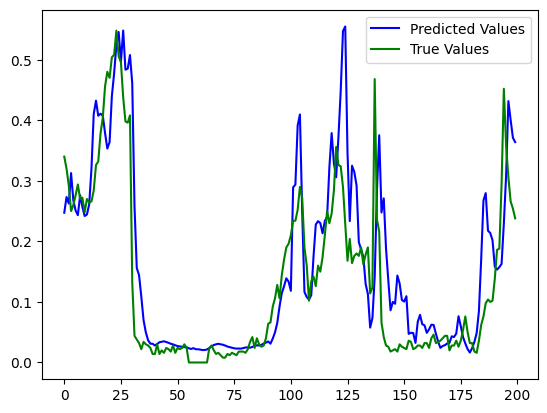

In [16]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values', color= 'blue')
plt.plot(test_results['Actual'][:200], label='True Values', color = 'green')
plt.legend()
plt.show()

In [16]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.13012


# THANK YOU

In [17]:
cd ..

c:\Users\Abdul\Desktop\Subjects\PROJECT 1\Pollution Prediction System


In [18]:
import joblib

joblib.dump(scaler, "scaler_ol.joblib")
best_model.save('model_ol')

INFO:tensorflow:Assets written to: model_ol\assets


INFO:tensorflow:Assets written to: model_ol\assets
